# Beta Hedging
因子模型假定
 $$Y = \alpha + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n$$
某一個資產Y的收益率可以被其他資產的線性組合所解釋，因為是一個線性模型，我們可以用回歸來估計 $\beta$

## 什麼是Beta的意義
$$Y_{2330} = \alpha + \beta X_{台灣50}$$
我們也可以考慮多$\beta$
$$Y_{2330} = \alpha + \beta_1 X_{台灣50} + \beta_2 X_{foxconn}$$

In [1]:
# Import libraries
import numpy as np
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

/home/qin/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import pandas as pd
import sqlite3

db = sqlite3.connect('/home/qin/workspace/python_finance_tutorial/gentle_start/TWStock_2')
tsmc = pd.read_sql(con=db,sql='SELECT * FROM "2330"')
tw_50 = pd.read_sql(con=db,sql='SELECT * FROM "0050"')

In [3]:
def clean_data(df):
    df.index = pd.to_datetime(df['Date'])
    df = df[['開盤價','最高價','最低價','收盤價']]
    df.columns = ['O','H','L','C']
    cols = df.columns
    df[cols] = df[cols].apply(pd.to_numeric,errors='coerce')
    df = df['2015-01-01':'2016-01-01']
    return df

tsmc = clean_data(tsmc)
tw_50 = clean_data(tw_50)

/home/qin/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [4]:
tsmc.head()

,O,H,L,C
Date,,,,
2015-01-05,140.5,140.5,137.5,139.5
2015-01-06,137.5,137.5,133.0,133.5
2015-01-07,133.5,135.0,133.5,134.0
2015-01-08,136.5,138.0,136.0,138.0
2015-01-09,135.0,135.5,133.0,134.0


In [5]:
tw_50.head()

,O,H,L,C
Date,,,,
2015-01-05,66.40,66.75,66.00,66.55
2015-01-06,65.75,65.75,64.75,64.90
2015-01-07,64.70,65.25,64.70,65.00
2015-01-08,65.50,66.60,65.50,66.50
2015-01-09,66.90,66.95,66.05,66.15


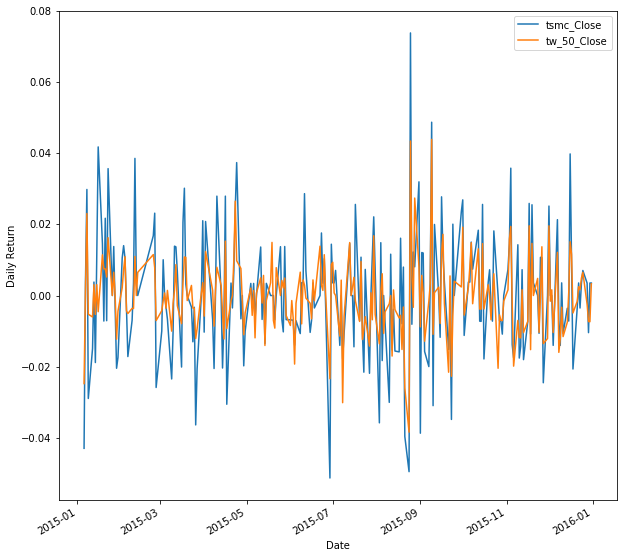

In [6]:

fig = plt.figure(figsize=(10,10))

r_a = tsmc.C.pct_change()[1:]
r_b = tw_50.C.pct_change()[1:]

r_a.name = 'tsmc_Close'
r_b.name = 'tw_50_Close'

# Let's plot them just for fun
r_a.plot()
r_b.plot()
plt.ylabel("Daily Return")
plt.legend();


In [7]:
# Let's define everything in familiar regression terms
X = r_b.values # Get just the values, ignore the timestamps
Y = r_a.values

def linreg(x,y):
    # We add a constant so that we can also fit an intercept (alpha) to the model
    # This just adds a column of 1s to our data
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    # Remove the constant now that we're done
    x = x[:, 1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)
print ('alpha: ' + str(alpha))
print ('beta: ' + str(beta))

alpha: 0.0006494481648138802
beta: 1.248349553203811


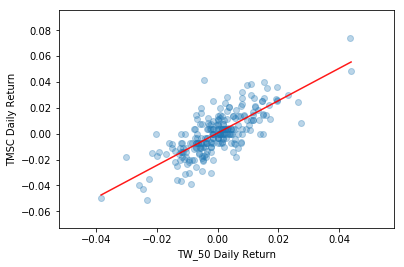

In [8]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha

plt.scatter(X, Y, alpha=0.3) # Plot the raw data
plt.xlabel("TW_50 Daily Return")
plt.ylabel("TMSC Daily Return")

 # Add the regression line, colored in red
plt.plot(X2, Y_hat, 'r', alpha=0.9);

所以在這邊，我們把收益率拆成兩個部份一個是跟市場收益率同方向的部份，另一個是本身帶來的超額收益率。 而這邊高的beta代表當市場上漲時，這隻股票會有比較大的漲幅，但同時，當下跌時，這隻股票會有比較大的跌幅。而我們也可利用這層關係建立對沖，具體的作法就是，當我們買入一單位的股票之後，我們做空beta單位的bechmark，則我們的收益率就變成完全取決於股票本身的超額報酬，這也是對沖基金基本的想法

## Market Neutral
當我們的策略的beta值為0，我們稱它為Market Neutral。
而把策略做成market netural的好處就是減少我們策略的的波動性，這也代表我們可以提供我們的槓桿，壞處就是在市場表現OK的情況下，我們的收益率會降低。下面是一個例子

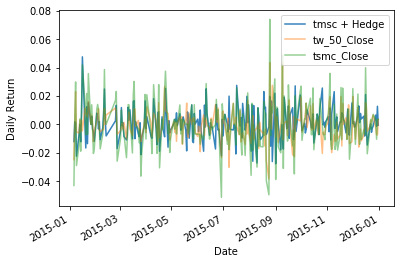

In [9]:
# Construct a portfolio with beta hedging
portfolio = -1*beta*r_b + r_a
portfolio.name = "tmsc + Hedge"

# Plot the returns of the portfolio as well as the asset by itself
portfolio.plot(alpha=0.9)
r_b.plot(alpha=0.5);
r_a.plot(alpha=0.5);
plt.ylabel("Daily Return")
plt.legend();

In [13]:
print("means: ", portfolio.mean(), r_a.mean())
print("volatilities: ", portfolio.std(), r_a.std())


means:  0.0006494481648138799 0.0002500101350927969
volatilities:  0.0111780128235949 0.017265073167151843


In [14]:
P = portfolio.values
alpha, beta = linreg(X,P)
print('alpha: ' + str(alpha))
print('beta: ' + str(beta))

alpha: 0.0006494481648138798
beta: 3.5952144039619327e-16


### 估計Beta的困難
因為beta可能會隨時間更動，所以用過去時間估計的beta可能無法成功的將市場波動改避免掉，所以在實務上如何估計beta是一個困難的問題。

### 基於Beta的策略
如果我們採用以上的方法把Beta沖掉，那就是一般的alpha策略，但我們可以有另外一種想法，就是，因為我們知道當市場上漲時，beta比較大的股票會上漲比較大，而在下跌時，Beta比較低的股票會下跌比較低，所以如果我們可以判斷目前市場的趨勢，那我們就在市場上漲時增大beta值，在市場下跌時，減少資產的beta值。

### 討論：怎麼構建一個Beta策略